<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [254]:
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Setup

In [234]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

## Constantes

In [216]:
SEMENTE = 2008193

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string
ATIVACAO = 'sigmoid'

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

DIRETORIO_TB = 'tb_nlp'

## Funções

In [137]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-28 01:28:07--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py.1’

funcoes.py.1        100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-28 01:28:07 (47.9 MB/s) - ‘funcoes.py.1’ saved [5196/5196]



In [138]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [246]:
def avaliar_modelo(previsao, validacao=y_test):
    print(classification_report(validacao, previsao))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [140]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-28 01:28:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2023-01-28 01:28:08 (65.1 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [141]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [142]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [143]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [144]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [145]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

### Vetorização (Vectorization)

In [146]:
limite_dicionario = 10000
media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))

vetorizador = TextVectorization(max_tokens=limite_dicionario,                     # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',        # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                               # (Default) Separador de tokens.
                                ngrams=None,                                      # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                                # (Default) Como mapear tokens para números.
                                output_sequence_length=media_palavras_por_texto)  # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [147]:
vetorizador.adapt(X_train)

In [148]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

A wasp just dive bombed my face


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   3, 6887,   31,    1,  412,   13,  269,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [149]:
vocabulario = vetorizador.get_vocabulary()

In [150]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [151]:
incorporador = Embedding(input_dim=limite_dicionario,            # Tamanho do vocabulário de entrada.
                         output_dim=128,                         # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=media_palavras_por_texto)  # Tamanho do texto de entrada.

In [152]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

the pastor was not in the scene of the accident......who was the owner of the range rover ?


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0350152 , -0.04964119, -0.03070915, ..., -0.02603972,
          0.00210096,  0.00371355],
        [ 0.00471605, -0.03607018, -0.01358086, ..., -0.04757296,
          0.01105428, -0.01327064],
        [ 0.01237269,  0.01338034,  0.02954981, ..., -0.00799332,
         -0.04332491,  0.02858119],
        ...,
        [ 0.03578708, -0.01896843, -0.04414504, ...,  0.033973  ,
          0.02954818, -0.01145656],
        [-0.02468921,  0.04980454, -0.00615562, ...,  0.00971152,
          0.02183679,  0.00163559],
        [ 0.0350152 , -0.04964119, -0.03070915, ..., -0.02603972,
          0.00210096,  0.00371355]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

In [235]:
modelos = [None] * 8
avaliacoes = [None] * 8
previsoes = [None] * 8
relatorios = [None] * 8
historicos = [None] * 8

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [236]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                       ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [237]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [238]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



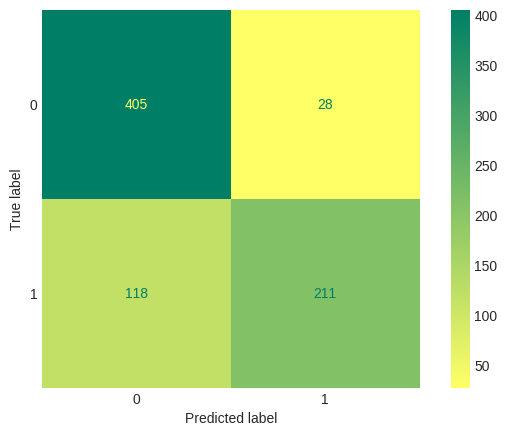

In [247]:
relatorios[0] = avaliar_modelo(previsoes[0])

In [240]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}

### Modelo 1: Feed-forward neural network (dense model)

In [259]:
modelo_nome = 'modelo_1_dense'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(1, activation=ATIVACAO, name='camada_saida')(camadas)

modelos[1] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[1].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[1] = modelos[1].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_1_dense/20230128-022651'.
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.4570 - accuracy: 0.8659 - val_loss: 0.4408 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2578 - accuracy: 0.9229 - val_loss: 0.4206 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2000 - accuracy: 0.9399 - val_loss: 0.4322 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1692 - accuracy: 0.9492 - val_loss: 0.4523 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1484 - accuracy: 0.9530 - val_loss: 0.4757 - val_accuracy: 0.7913


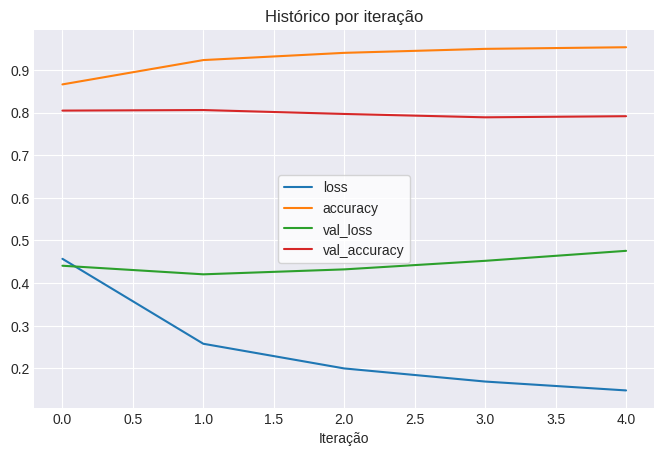

In [260]:
grafico_historico_por_iteracao(historicos[1])

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       433
           1       0.76      0.76      0.76       329

    accuracy                           0.79       762
   macro avg       0.79      0.79      0.79       762
weighted avg       0.79      0.79      0.79       762



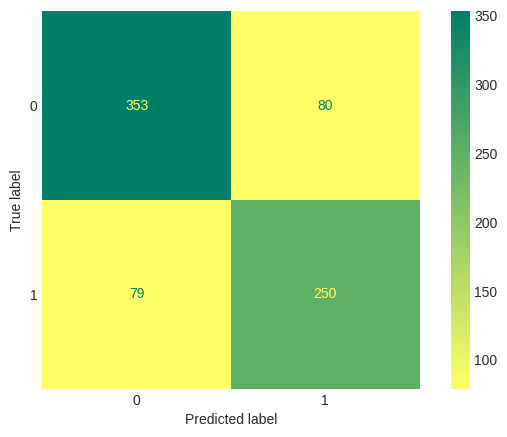

In [261]:
avaliacoes[1] = modelos[1].evaluate(X_test, y_test)
previsoes[1] = tf.squeeze(tf.round(modelos[1].predict(X_test)))
relatorios[1] = avaliar_modelo(previsoes[1])

In [262]:
relatorios[1]

{'acuracia': 0.7913385826771654,
 'precisao': 0.7914167373649,
 'revocacao': 0.7913385826771654,
 'pontuacao-f1': 0.7913762858462414}